In [191]:
import nltk
from nltk.stem import PorterStemmer #for stem of a word
import numpy as np
import pandas as pd
import random
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import pycrfsuite #Using python-crfsuite for CRF model training
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

# 1. Dataset

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### Unique tags in the dataset

In [3]:
tags_brown = [[tag for word, tag in sentence] for sentence in nltk_data]
unique_tags = set([tag for sublist in tags_brown for tag in sublist])
print(unique_tags)

{'ADP', 'DET', 'NOUN', 'VERB', '.', 'PRT', 'X', 'NUM', 'CONJ', 'PRON', 'ADJ', 'ADV'}


# 2. Feature extraction

### Features used:
##### Features based on the word itself  
- Stem
- Suffix
- Word length
- Word position
##### Contextual features  
- Previous word
- POS tag of the previous word
- Next word
##### Word position  
- Is the first word (boolean value)
- Is the last word (boolean value)

### Stem extractor function
Using nltk porter stemmer

In [4]:
#stemmer object
stemmer = PorterStemmer()

In [5]:
#Example of the stem function
stemmer.stem('throwing')

'throw'

### Feature extractor function
- This function will take the statement and the word index as the input.
- The reason for giving the entire statement as the input is that we need to capure the positional and contextual features too

In [6]:
def features(statement, word_idx):#outputs a dictionary of named features

   curr_word = statement[word_idx]
   curr_stem = stemmer.stem(curr_word)
   curr_suffix = curr_word[len(curr_stem):] #Part of the word after the stem
   is_first_word = 1 if word_idx == 0 else 0
   is_last_word = 1 if (word_idx == len(statement) - 1) else 0
   feature_dict = {
      'word_stem': curr_stem,
      'word_suffix': curr_suffix,
      'word_length': len(statement[word_idx]),
      'word_position': word_idx + 1,
      'prev_word': statement[word_idx - 1] if is_first_word == 0 else '^',
      'next_word': statement[word_idx + 1] if is_last_word == 0 else '.',
      'is_first_word': is_first_word,
      'is_last_word': is_last_word
   }
   return feature_dict

#### Testing the feature extractor function

In [7]:
tokenized_sentence = ['I', 'jumped', 'the', 'signal']
features(tokenized_sentence, 1)

{'word_stem': 'jump',
 'word_suffix': 'ed',
 'word_length': 6,
 'word_position': 2,
 'prev_word': 'I',
 'next_word': 'the',
 'is_first_word': 0,
 'is_last_word': 0}

# 3. Data preparation

- List of feature dictonaries for each word of each sentence

In [146]:
features_brown = [] #list of dictionaries holding the features for each word of each sentence
sentences_brown = [[word for word, tag in sentence] for sentence in nltk_data]
for sentence in sentences_brown:
    sentence_features = []
    for i in range(len(sentence)):
        sentence_features.append(features(sentence, i))
    features_brown.append(sentence_features)

- List of list of tags for each word of each sentence

In [147]:
tags_brown = [[tag for word, tag in sentence] for sentence in nltk_data]

### Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features_brown, tags_brown, test_size=0.2, random_state=11)

# 4. Model training

In [ ]:
trainer = pycrfsuite.Trainer() # Creating a CRF trainer object

for x, y in zip(X_train, y_train): # Adding train data to the trainer
    trainer.append(x, y)

# Train the model and save it as a file named 'crf_model.crfsuite'
trainer.train('crf_model.crfsuite')

### Fetching the tagger function for the final tagging task

In [9]:
sub_tagger = pycrfsuite.Tagger()
sub_tagger.open('crf_model.crfsuite')

### Defining the sub tagger as a function on sentences 

In [10]:
def sub_tagger_func(sentence):
    # tokens = regex_tokenize(sentence)
    features_test = []
    for i in range(len(sentence)):
        features_test.append(features(sentence, i))
    return sub_tagger.tag(features_test)

# 5. Preparing the stacked model

In [11]:
def stack_features(statement, word_idx):#outputs a dictionary of named features
   curr_word = statement[word_idx]
   curr_stem = stemmer.stem(curr_word)
   curr_suffix = curr_word[len(curr_stem):] #Part of the word after the stem
   is_first_word = 1 if word_idx == 0 else 0
   is_last_word = 1 if (word_idx == len(statement) - 1) else 0
   prev_pos_tag = sub_tagger_func(statement)[word_idx - 1] if word_idx > 0 else '^'
   feature_dict = {
      'word_stem': curr_stem,
      'word_suffix': curr_suffix,
      'word_length': len(statement[word_idx]),
      'word_position': word_idx + 1,
      'prev_word': statement[word_idx - 1] if is_first_word == 0 else '^',
      'next_word': statement[word_idx + 1] if is_last_word == 0 else '.',
      'is_first_word': is_first_word,
      'is_last_word': is_last_word,
      'prev_pos_tag': prev_pos_tag
   }
   return feature_dict

### Generating the features for the stacked model for training and validation

In [12]:
stack_features_brown = [] #list of dictionaries holding the features for each word of each sentence
sentences_brown = [[word for word, tag in sentence] for sentence in nltk_data]
for sentence in sentences_brown:
    sentence_features = []
    for i in range(len(sentence)):
        sentence_features.append(stack_features(sentence, i))
    stack_features_brown.append(sentence_features)

In [14]:
import json
with open("stack_features_brown.json", "w") as file:
    json.dump(stack_features_brown, file, indent=4)

In [16]:
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(stack_features_brown, tags_brown, test_size=0.2, random_state=11)

In [17]:
trainer = pycrfsuite.Trainer() # Creating a CRF trainer object

for x, y in zip(X_train_fin, y_train_fin): # Adding train data to the trainer
    trainer.append(x, y)

# Train the model and save it as a file named 'crf_model.crfsuite'
trainer.train('crf_model_stacked.crfsuite')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 260219
Seconds required: 2.179

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 2140454.605663
Feature norm: 0.150009
Error norm: 3705361.148256
Active features: 260219
Line search trials: 2
Line search step: 0.000000
Seconds required for this iteration: 2.997

***** Iteration #2 *****
Loss: 2044501.571763
Feature norm: 0.156552
Error norm: 1093586.652876
Active features: 260219
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 1.048

***** Iteration #3 *****
Loss: 2027388.901754
Feature norm: 0.174379
Error norm: 1003548.517410
Active features: 260219
Line search trials: 1
Line search step: 1.0000

In [13]:
main_tagger = pycrfsuite.Tagger()
main_tagger.open('crf_model_stacked.crfsuite')

# 6. Evaluation of the stacked model

### Overall accuracy

In [63]:
#Lets calculate the accuracy on testset
y_pred_fin = []
for feature_extracted_sentence in X_test_fin:
    y_pred_fin.append(main_tagger.tag(feature_extracted_sentence))
#now lets calc accuracy
#LETS get y_true which contains all tags
y_true = list([tag for sentence in y_test_fin for tag in sentence])
y_pred = list([tag for sentence in y_pred_fin for tag in sentence])
#lets get accuracy
avg_accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy of the stacked model: {100*avg_accuracy}")

Accuracy of the stacked model: 96.73327995135675


### Per POS tag accuracy

In [66]:
#Now lets calc the Per POS tag accuracy
total = Counter()
correct = Counter()
#We will get an array of all possible tags in test set. This will be used to calculate the accuracy of each tag.
all_tags = list(set([tag for sentence in y_test_fin for tag in sentence]))
for pred_sentence, true_sentence in zip(y_pred_fin, y_test_fin):
    for pred_tag, true_tag in zip(pred_sentence, true_sentence):
        total[true_tag] += 1
        if pred_tag == true_tag:
            correct[true_tag] += 1
#Now lets calculate the accuracy of each tag
accuracy_per_tag = {}
for tag in all_tags:
    accuracy_per_tag[tag] = (correct[tag] / total[tag])*100

accuracy_per_tag

{'ADP': 98.17417665702081,
 'DET': 99.37034088441776,
 'NOUN': 97.32424586646472,
 'VERB': 96.78714859437751,
 '.': 100.0,
 'PRT': 92.24702131230073,
 'X': 29.482071713147413,
 'NUM': 84.20356906807666,
 'CONJ': 99.6124031007752,
 'PRON': 98.21209644462607,
 'ADJ': 89.09025873375462,
 'ADV': 90.37540283947392}

### Confusion matrix 

In [124]:
conf_matrix = confusion_matrix(y_true,y_pred, labels=all_tags)
conf_matrix_df = pd.DataFrame(conf_matrix, index=all_tags, columns=all_tags)
conf_matrix_df

,ADP,DET,NOUN,VERB,.,PRT,X,NUM,CONJ,PRON,ADJ,ADV
ADP,28498,28,36,31,1,270,1,0,21,13,13,116
DET,72,27460,10,0,0,0,2,0,8,74,0,8
NOUN,10,9,53977,580,0,7,32,80,0,2,707,57
VERB,34,0,961,35668,0,2,2,0,0,0,167,18
.,0,0,0,0,29543,0,0,0,0,0,0,0
PRT,295,0,105,14,1,5497,0,0,0,1,11,35
X,5,5,146,5,2,0,74,0,1,4,7,2
NUM,0,0,391,22,0,0,4,2548,0,0,56,5
CONJ,2,13,4,0,0,0,1,0,7710,0,0,10
PRON,63,87,19,2,0,0,1,0,0,9613,2,1


### Heatmap of the Confusion matrix

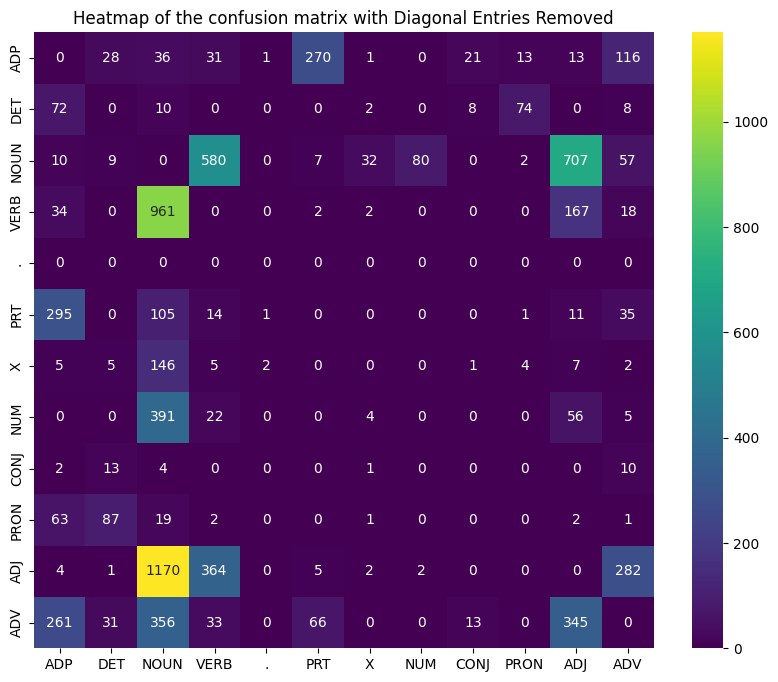

In [125]:
heatmap_df = conf_matrix_df.copy()
np.fill_diagonal(heatmap_df.values, 0)

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size if necessary
sns.heatmap(heatmap_df, fmt=".0f", annot=True, cmap="viridis", cbar=True)
plt.title("Heatmap of the confusion matrix with Diagonal Entries Removed")
plt.show()

### Per POS tag F1 score

In [139]:
f1_per_tag = {}
f05_per_tag = {}
f2_per_tag = {}
precision_per_tag = {}
recall_per_tag = {}

for tag in all_tags:
    precision = conf_matrix_df.loc[tag, tag] / sum(conf_matrix_df.loc[tag, :])
    recall = conf_matrix_df.loc[tag, tag] / sum(conf_matrix_df.loc[:, tag])
    precision_per_tag[tag] = precision
    recall_per_tag[tag] = recall
    f1_per_tag[tag] = 2 * (precision * recall) / (precision + recall)
    f05_per_tag[tag] = 5 * (precision * recall) / (precision + recall)
    f2_per_tag[tag] = 1.25 * (precision * recall) / (precision + recall)

In [142]:
print("F1 score per tag:")
f1_per_tag

F1 score per tag:


{'ADP': 0.9781026908292147,
 'DET': 0.9937034088441775,
 'NOUN': 0.9584324727440606,
 'VERB': 0.9696211822593143,
 '.': 0.9999323066508715,
 'PRT': 0.9312214128409283,
 'X': 0.4,
 'NUM': 0.900990099009901,
 'CONJ': 0.99528819466856,
 'PRON': 0.9862015901513209,
 'ADJ': 0.9049839520377884,
 'ADV': 0.9268009468089857}

## Overall F1 score

In [145]:
Overall_TP = 0
Overall_FP = 0
Overall_FN = 0

for tag in all_tags:
    Overall_TP += conf_matrix_df.loc[tag, tag]
    Overall_FP += sum(conf_matrix_df.loc[tag, :]) - conf_matrix_df.loc[tag, tag] 
    Overall_FN += sum(conf_matrix_df.loc[:, tag]) - conf_matrix_df.loc[tag, tag]

Overall_precision = Overall_TP/(Overall_TP + Overall_FP)
Overall_recall = Overall_TP/(Overall_TP + Overall_FN)
Overall_F1_score = 2*(Overall_precision*Overall_recall)/(Overall_precision + Overall_recall)
print(f"Overall_precision: {Overall_precision} \nOverall_recall: {Overall_recall} \nOverall_F1_score: {Overall_F1_score} \nOverall_F2_score: {0.625*Overall_F1_score} \nOverall_F0.5_score: {2.5*Overall_F1_score}")

Overall_precision: 0.9673327995135674 
Overall_recall: 0.9673327995135674 
Overall_F1_score: 0.9673327995135674 
Overall_F2_score: 0.6045829996959796 
Overall_F0.5_score: 2.4183319987839185


### The stacked model doesn't provide any significant accuracy improvement over the unstacked model, while it takes significantly longer time to train. So the 5 fold cross validation will be done on the unstacked model

# 7. Final model with 5 fold cross validation

### Splitting the data into 5 folds and iteratively training and validating for each fold  

In [192]:
def kfold_split_5(features_list, tags_list):
    for i in range(5):
        X_1_rest, X_1, y_1_rest, y_1 = train_test_split(features_brown, tags_brown, test_size=0.2, random_state=11)
        X_2_rest, X_2, y_2_rest, y_2 = train_test_split(X_1_rest, y_1_rest, test_size=0.25, random_state=11)       
        X_3_rest, X_3, y_3_rest, y_3 = train_test_split(X_2_rest, y_2_rest, test_size=0.3333, random_state=11) 
        X_5, X_4, y_5, y_4 = train_test_split(X_3_rest, y_3_rest, test_size=0.5, random_state=11) 
    
    permutations = [
        ([list(chain(X_2, X_3, X_4, X_5)), X_1], [list(chain(y_2, y_3, y_4, y_5)), y_1]),
        ([list(chain(X_1, X_3, X_4, X_5)), X_2], [list(chain(y_1, y_3, y_4, y_5)), y_2]),
        ([list(chain(X_1, X_2, X_4, X_5)), X_3], [list(chain(y_1, y_2, y_4, y_5)), y_3]),
        ([list(chain(X_1, X_2, X_3, X_5)), X_4], [list(chain(y_1, y_2, y_3, y_5)), y_4]),
        ([list(chain(X_1, X_2, X_3, X_4)), X_5], [list(chain(y_1, y_2, y_3, y_4)), y_5])
    ]
    return permutations           

In [193]:
train_test_folds = kfold_split_5(features_brown, tags_brown)

### Training the model on the 5 folds

In [180]:

for i in range(5):
    trainer = pycrfsuite.Trainer() # Creating a CRF trainer object

    for x, y in zip(train_test_folds[i][0][0], train_test_folds[i][1][0]): # Adding train data to the trainer
        trainer.append(x, y)

    trainer.train(f"crf_model_stacked{i}.crfsuite")

# 6 Final function for GUI window

In [94]:
def final_func(sentence):
    tokens = sentence.split()
    features_test = []
    for i in range(len(tokens)):
        features_test.append(stack_features(tokens, i))
    return main_tagger.tag(features_test)

### Final output function

In [96]:
import gradio as gr

# Define the Gradio interface
interface = gr.Interface(
    fn= final_func,                       # Function that processes input
    inputs="text",                       # Input type: Text field for the user
    outputs="text",                      # Output type: Text display for POS tags
    title="Stacked CRF based Part-of-Speech Tagger",       # Title of the UI
    description="Enter a sentence and get the Part-of-Speech tags."  # Description
)

# Launch the UI in a browser
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
